In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
from tqdm.notebook import tqdm
from copy import copy, deepcopy
import os

from datetime import datetime


#np.set_printoptions(precision=4)

In [2]:
def numberToBase(n, b, num_digits):
    digits = []
    while n:
        digits.append(int(n % b))
        n //= b

    while len(digits) < num_digits:
        digits.append(0)
    return digits[::-1]

class RBM:
    def __init__(self,
                 n_vis=None, 
                 n_hid=None,
                 hamiltonian=None,
                 num_walkers=100,
                 num_steps=1000,):
        self.n_vis = n_vis
        self.n_hid = n_hid

        # Initialize parameters
        scale = 1#/np.sqrt(n_hid)
        self.W_r = np.random.normal(0, 1/scale, (n_vis, n_hid))
        self.W_i = np.random.normal(0, 1/scale, (n_vis, n_hid))
        
        self.b_r = np.random.normal(0, 1/scale, (n_vis, 1))
        self.b_i = np.random.normal(0, 1/scale, (n_vis, 1))
        
        self.c_r = np.random.normal(0, 1/scale, (1, n_hid))
        self.c_i = np.random.normal(0, 1/scale, (1, n_hid))
        self.params = [self.b_r, self.b_i, self.c_r, self.c_i, self.W_r, self.W_i]

        self.adam = Adam()

        self.hamiltonian = hamiltonian
        self.num_walkers = num_walkers
        self.num_steps = num_steps

        self.mcmc_state = np.random.randint(2, size=(num_walkers, self.n_vis))

        # Generate all possible states
        all_states_list = []
        for i in range(2**self.n_vis):
            state = numberToBase(i, 2, self.n_vis)
            all_states_list.append(state)
        self.all_states = np.array(all_states_list)

    def unnormalized_amplitude(self, state):
        Wstate = np.matmul(state, self.W_r) + 1j*np.matmul(state, self.W_i)
        exponent = Wstate + self.c_r + 1j*self.c_i
        A = np.exp(-exponent)
        A = np.prod(1+A, axis=1, keepdims=True)
        A = A*np.exp(-np.matmul(state, self.b_r) - 1j*np.matmul(state, self.b_i))
        return A
    
    def amplitude(self, state):
        # Normalized amplitude
        Z = np.sqrt(np.sum(np.abs(self.unnormalized_amplitude(self.all_states))**2))
        return self.unnormalized_amplitude(state)/Z
    
    def probability(self, state):
        return np.abs(self.amplitude(state))**2
    
    def mcmc_step(self):
        P = self.probability(self.mcmc_state)
        mcmc_state_prime = copy(self.mcmc_state)
        
        random_index = np.random.randint(self.n_vis, size=self.num_walkers)
        mask = np.zeros((self.num_walkers, self.n_vis), dtype=bool)
        mask[np.arange(self.num_walkers), random_index] = True
        mcmc_state_prime[mask] = 1 - mcmc_state_prime[mask]

        P_prime = self.probability(mcmc_state_prime)
        accept = np.random.uniform(0, 1, (self.num_walkers)) < (P_prime/P).reshape(-1)
        self.mcmc_state[accept] = mcmc_state_prime[accept]

    def mcmc(self, num_steps, burn_in=100):
        sample_list = []
        for i in range(num_steps + burn_in):
            self.mcmc_step()
            if i > burn_in:
                sample_list.append(copy(self.mcmc_state))
            
        return np.concatenate(sample_list, axis=0)
        
    
    def wave_function(self):
        return self.amplitude(self.all_states)
    
    def local_energy(self, state):
        batch_size = state.shape[0]
        E = np.zeros((batch_size, 1), dtype=np.complex128)
        a1 = self.amplitude(state)
        
        powers = np.array([2**i for i in reversed(range(self.n_vis))]).reshape(1,-1)#weights for converting binary to index
        state_indicies = np.sum(state*powers, axis = 1) # convert batch of states to batch of indicies

        #iterate over all possible state_primes, can be optimized with knowledge of hamiltonian
        for i in range(2**self.n_vis):
            state_prime = np.array(numberToBase(i, 2, self.n_vis)).reshape(1,-1)
            a2 = self.amplitude(state_prime)

            h_slice = (self.hamiltonian[state_indicies, i]).reshape(-1,1) # pick out elements according to (batch) state and (single) state_prime
            E += (h_slice/a1)*a2
        
        return E
    
    def exact_energy(self):
        wave_function = self.wave_function()
        E = wave_function.conj().T @ self.hamiltonian @ wave_function
        return E.real

    def estimate_energy(self):
        sampled_states = self.mcmc(num_steps=self.num_steps)
        return np.mean(self.local_energy(sampled_states)).real
    
    def omega(self):
        omega_list = []
        
        b_grad = self.b_grad(self.all_states).T
        c_grad = self.c_grad(self.all_states).T
        W_grad = self.W_grad(self.all_states).T
        
        A = self._diag(b_grad)
        omega_list.extend([A, 1j*A])

        A = self._diag(c_grad)
        omega_list.extend([A, 1j*A])

        A = self._diag(W_grad)
        omega_list.extend([A, 1j*A])
        
        return omega_list
    
    def _diag(self, A):
        # hack to make batch of vectors into batch of diagonal matrices
        num_params = A.shape[1]
        A = np.expand_dims(A, axis=1)
        A = A*np.eye(num_params)
        return A
    
    def b_grad(self, state):
        return -state
    
    def c_grad(self, state):
        exponent = np.matmul(state, self.W_r) + 1j*np.matmul(state, self.W_i)
        exponent += self.c_r + 1j*self.c_i
        A = -np.exp(-exponent)/(1+np.exp(-exponent))
        return A
    
    def W_grad(self, state):
        batch_size = state.shape[0]
        A = self.c_grad(state)
        #batch-wise outer product between c_grad and state
        A = np.einsum('ij,ik->ijk', state, A).reshape(batch_size,-1)
        return A

    def finite_grad(self, h=0.001):
        grad_list = []
        for param in self.params:
            grad_array = np.zeros(param.shape)
            for i in range(param.shape[0]):
                for j in range(param.shape[1]):
                    param[i,j] += h
                    E1 = self.exact_energy()
                    param[i,j] -= 2*h
                    E2 = self.exact_energy()
                    param[i,j] += h
                    grad = (E1-E2)/(2*h)
                    grad_array[i,j] = grad
                    
            grad_list.append(grad_array)

        return grad_list
    
    def analytical_grad(self):
        grad_list = []
        omega = self.omega()
        wf = self.wave_function()
        H = self.hamiltonian
        print(omega)
        # loop over b, c and W
        for i, O in enumerate(omega):
            EO = wf.conj().T @ H @ O @ wf
            E = wf.conj().T @ H @ wf
            O = wf.conj().T @ O @ wf
            grad = 2*(EO - E*O)
            
            
            # reshape according to b, c or W
            if i==0 or i==1:
                grad = grad.reshape(-1,1)
            elif i==2 or i==3:
                grad = grad.reshape(1,-1)
            else:
                grad = grad.reshape(self.n_vis, self.n_hid)

            grad_list.append(grad.real)
        
        return grad_list
    
    def train(self, iter=100, lr = 0.01, analytical_grad=True):
        energy_list = []
        for i in range(iter):
            if analytical_grad:
                grad_list = self.analytical_grad()
            else:
                grad_list = self.finite_grad()
            grad_list = self.adam.step(grad_list)
            for param, grad in zip(self.params, grad_list):
                param -= lr*grad
            energy_list.append(self.exact_energy()[0,0])
            #print(energy_list[-1])

        return energy_list


class Adam:
    def __init__(self, beta1=0.9, beta2=0.999, eps=1e-8):
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
        self.t = 0
        self.m = None
        self.v = None
    
    def step(self, grad_list):
        self.t += 1
        if self.t == 1:
            self.m = [np.zeros_like(grad) for grad in grad_list]
            self.v = [np.zeros_like(grad) for grad in grad_list]

        mod_grad_list = []
        for i, grad in enumerate(grad_list):
            self.m[i] = self.beta1*self.m[i] + (1-self.beta1)*grad
            self.v[i] = self.beta2*self.v[i] + (1-self.beta2)*grad**2
            m_hat = self.m[i]/(1-self.beta1**self.t)
            v_hat = self.v[i]/(1-self.beta2**self.t)
            mod_grad_list.append(m_hat/(np.sqrt(v_hat) + self.eps))
        
        return mod_grad_list
    

def random_hamiltonian(d):
    H = np.random.normal(0, 1, (d, d)) + 1j*np.random.normal(0, 1, (d, d))
    H = H + np.conj(H).T
    return H

## Testing hidden node accuracy

Training several RBMs with increasing number of visible nodes. For each RBM we test how increasing the number of hidden nodes affects accuracy.

In [3]:

#Initializing starting values 
n_vis = 2
vis_inc = 1
total_vis = 7


n_hid_start = 2
n_hid = n_hid_start
hid_inc = 2
total_hid = 5

energy_list = []
n_hid_list =[]

seed = 45

path = f"C:/Users/Sebastian/Desktop/rbm_plots_{datetime.now().strftime('%Y.%m.%d_%H%M%S')}"
os.makedirs(path)

for i in tqdm(range(total_vis), position=0, desc=f"Total", leave=False, colour='green'):
    
    #Finding true ground state energy and displaying it
    np.random.seed(seed)
    hamiltonian = random_hamiltonian(2**n_vis)
    eig,_ = np.linalg.eigh(hamiltonian)
    E_truth = np.min(eig)
    #print(f"Energy truth: {E_truth}")
    
    for j in tqdm(range(total_hid), position=1, desc=f"Training", leave=False, colour='red'):
        np.random.seed(seed)
        hamiltonian = random_hamiltonian(2**n_vis)

        rbm = RBM(n_vis=n_vis, n_hid=n_hid, hamiltonian=hamiltonian)
        energy_list.append(rbm.train(iter=1000, lr=0.01))
        n_hid_list.append(n_hid)
        n_hid *= hid_inc
    
    # Print loop    
    labels = [f"Hidden = {i}" for i in n_hid_list]
    labels.append("True energy")
    
    plt.ioff() # uncomment to stop plotting in notebook
    plt.figure(i)
    
    
    for energy in energy_list:
        plt.plot(energy)
        plt.xlabel('Gradient steps')
        plt.ylabel('Energy')

    plt.title(f"Training of RBM with {n_vis} visible nodes")
    plt.axhline(y=E_truth, color='k', linestyle='--')
    plt.legend(labels)

    # Save figure as pdf
    plt.savefig(f"{path}/{n_vis}nodes.pdf")
    
    n_vis += vis_inc
    n_hid = n_hid_start
    energy_list.clear()
    n_hid_list.clear()
    labels.clear()



Total:   0%|          | 0/7 [00:00<?, ?it/s]

Training:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/5 [00:00<?, ?it/s]

KeyboardInterrupt: 

## Local Energy Check

In [ ]:
n = 4
d = 2**n
np.random.seed(42)
hamiltonian = random_hamiltonian(d)
rbm = RBM(n_vis=n, n_hid=20, hamiltonian=hamiltonian, num_walkers=100)
samples = rbm.mcmc(num_steps=1000, burn_in=100)
print(samples.shape)

E = rbm.local_energy(samples)
print(np.mean(E))

print(rbm.exact_energy())

Energy truth: -30.31210895466823


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

2.343402149456913
2.007134471876217
1.6732640506050735
1.3419227598172125
1.0127580297105407
0.6854851677389089
0.36024310405200244
0.03744441953567745
-0.2823737960294118
-0.5985772986482325
-0.9104179525033428
-1.2170300816093755
-1.5174566253928805
-1.810697192000322
-2.095764866430544
-2.3717432171131385
-2.6378398048558034
-2.893434615184599
-3.1381219233383693
-3.371743398896636
-3.5944095709045008
-3.806506547938935
-4.0086853409949725
-4.201832296462947
-4.387020898161422
-4.565447436688151
-4.738355698467192
-4.906958505635342
-5.072365577254454
-5.235526502969654
-5.397194340297598
-5.557910769660568
-5.718009843700791
-5.877635370444699
-6.0367668273280275
-6.195249626219462
-6.352826732371806
-6.509169611998537
-6.6639071039085245
-6.8166511371378125
-6.967018385026023
-7.1146471017957875
-7.259208641749217
-7.4004135602996195
-7.5380127063531
-7.671794235902599
-7.801577882306236
-7.927208014402552
-8.048546967947175
-8.165469882856085
-8.277861894728709
-8.385618101081967

-12.853914735259059
-12.855996258674784
-12.858076453880031
-12.860155263275256
-12.862232627568872
-12.864308485796204
-12.866382775340213
-12.868455431954008
-12.870526389785203
-12.872595581402042
-12.874662937821435
-12.8767283885388
-12.878791861559789
-12.880853283433881
-12.882912579289844
-12.884969672873055
-12.887024486584746
-12.889076941523006
-12.891126957525762
-12.89317445321547
-12.895219346045742
-12.897261552349658
-12.899300987389928
-12.901337565410799
-12.903371199691579
-12.905401802601935
-12.907429285658782
-12.909453559584723
-12.911474534368066
-12.91349211932429
-12.915506223158987
-12.91751675403205
-12.91952361962328
-12.921526727199137
-12.92352598368064
-12.925521295712414
-12.927512569732603
-12.929499712043798
-12.931482628884705
-12.933461226502596
-12.93543541122634
-12.937405089539995
-12.93937016815681
-12.941330554093602
-12.943286154745273
-12.94523687795954
-12.947182632111602
-12.949123326178764
-12.951058869814783
-12.952989173423935
-12.954914

-13.399550678250415
-13.400673680121148
-13.401800161661637
-13.402930121707298
-13.40406355827707
-13.405200468560677
-13.406340848905863
-13.407484694805746
-13.408632000886104
-13.409782760892831


  0%|          | 0/1000 [00:00<?, ?it/s]

-0.6729735943391444
-0.8111815767551115
-0.9460446536826153
-1.0772360039875215
-1.204973540691928
-1.3299287122011523
-1.4529903200055356
-1.574972235420995
-1.6963975406106602
-1.8175023456371393
-1.938323217835294
-2.0587697378330354
-2.178665260339459
-2.297763993704364
-2.4157570429007036
-2.532279268304924
-2.646926246350623
-2.7592866658491824
-2.868990493767238
-2.975767956482896
-3.0795094354827586
-3.180312354152447
-3.2784997099884667
-3.3745993782402524
-3.469285592254393
-3.56329909756003
-3.657369432644872
-3.752156191079481
-3.8482129742246456
-3.9459685127929225
-4.04571739698771
-4.147614957860914
-4.251673600914168
-4.357759879918997
-4.465592757954321
-4.574744106687053
-4.684642746515935
-4.7945833518791074
-4.90374143710123
-5.011195496421356
-5.115957293554171
-5.2170113628790675
-5.313364998143371
-5.404110118345381
-5.488497673746249
-5.566022365658098
-5.636509026313234
-5.700182204446647
-5.757691392785976
-5.8100647108354675
-5.858582256777857
-5.904593716271

-19.88714223170553
-19.89443672928447
-19.901664964206297
-19.90882523511739
-19.915915970587996
-19.922935755632885
-19.929883340467207
-19.936757658014862
-19.943557834445606
-19.950283192779082
-19.956933262510148
-19.963507774491337
-19.970006661814914
-19.976430052811352
-19.98277826064331
-19.989051776169454
-19.995251251392283
-20.001377488961424
-20.007431425142528
-20.01341411334672
-20.019326708786156
-20.02517044860792
-20.030946637688345
-20.036656630271697
-20.04230181549527
-20.047883603069433
-20.053403408753425
-20.058862644077394
-20.064262704066195
-20.06960495977383
-20.07489075006965
-20.08012137566926
-20.08529809492284
-20.09042211923104
-20.09549461179169
-20.10051668519231
-20.105489401815646
-20.110413773918054
-20.115290764660415
-20.120121290149974
-20.12490622082977
-20.129646384602275
-20.13434256875785
-20.138995523249505
-20.143605963176736
-20.14817457155302
-20.15270200209804
-20.157188881362877
-20.16163581147878
-20.166043371824603
-20.170412121359067

  0%|          | 0/1000 [00:00<?, ?it/s]

4.931555360821962
4.580954498668394
4.200620853837432
3.7883458216555974
3.3446587724997805
2.8728015590850196
2.3783630696694784
1.8688288727488243
1.353063037907005
0.8405294052674881
0.3401878723581766
-0.1401567571492195
-0.5941733928798218
-1.0178103824951361
-1.409910610177115
-1.7717738409800026
-2.1063130447792036
-2.4173813567844826
-2.7091275688820398
-2.9853310684890055
-3.2488986346644717
-3.5016509801657856
-3.7443359037700494
-3.976731575834154
-4.19775620519828
-4.405573180072055
-4.597731186255556
-4.771404354200752
-4.923794726967996
-5.052719984953873
-5.157329900402675
-5.238787275280871
-5.300650523749246
-5.348681650268899
-5.389970849888583
-5.431601408395386
-5.47933758212241
-5.536773818558727
-5.605116072878525
-5.68351427840011
-5.769742004079829
-5.861001543808712
-5.9546671651779395
-6.048832512748073
-6.14258876651834
-6.236025781750207
-6.330011937869011
-6.425854130861598
-6.5249519725620075
-6.628537043606627
-6.737541868158158
-6.8525942381714176
-6.974

-22.384401529437874
-22.393817792309353
-22.403156958924633
-22.41241947540099
-22.421605832294027
-22.430716549472372
-22.43975216396838
-22.448713220683747
-22.45760026574568
-22.46641384224361
-22.475154488029272
-22.483822735234412
-22.492419111148838
-22.50094414010671
-22.509398346046773
-22.517782255441873
-22.526096400330744
-22.534341321228883
-22.542517569741534
-22.55062571074991
-22.558666324087053
-22.566640005661966
-22.5745473680282
-22.58238904042415
-22.590165668337757
-22.59787791266615
-22.605526448553242
-22.613111963993312
-22.620635158288863
-22.6280967404471
-22.63549742759123
-22.642837943452705
-22.650119016997927
-22.65734138123046
-22.6645057721961
-22.671612928206674
-22.67866358928603
-22.685658496832993
-22.692598393486733
-22.699484023174097
-22.706316131313265
-22.71309546514508
-22.719822774162157
-22.72649881060495
-22.73312432999589
-22.73970009168413
-22.74622685937657
-22.75270540163428
-22.75913649231743
-22.765520910965748
-22.771859443105885
-22.

-24.577784044345922
-24.581438238825562
-24.585277131915817
-24.58865923512253
-24.592655720657913
-24.596130602480876
-24.60000934863939
-24.60368241488862
-24.607363964203287
-24.611253926856634
-24.61488199530681
-24.618809482972708
-24.622502086376667
-24.62635012049801
-24.63020056707367
-24.633985858909522
-24.63792224181228
-24.641709440484327
-24.64564200608607
-24.649521781182287
-24.653423158478773
-24.657386532097053
-24.661278218449237
-24.66526818836025
-24.669211340731565
-24.673197501849938
-24.67720848515481
-24.68119282695904
-24.685238656029508
-24.689255336281718
-24.69331042240725
-24.69737947303046
-24.701443322578513
-24.705547461681252
-24.70963737924677
-24.713755701586543
-24.71788536100235
-24.722017621202077
-24.726179298342743
-24.730337479690483
-24.73451602533561
-24.738705970622796
-24.742900016612815
-24.74711570699351
-24.751333976863656
-24.75556717977248
-24.75981271672466
-24.764063004535895
-24.768329524572973
-24.772601439312936
-24.77688330448101


  0%|          | 0/1000 [00:00<?, ?it/s]

1.254089987932366
0.26119186277819484
-0.7151299817573643
-1.6072101285725322
-2.368000299263779
-2.9768964663777813
-3.4429037863597043
-3.7992800566522598
-4.088483724660712
-4.347005476266171
-4.597981412531897
-4.85156777839074
-5.10831476285898
-5.362544621477045
-5.605298973405167
-5.827122704261178
-6.020604276445868
-6.182201627031596
-6.312802959131373
-6.416908370537755
-6.500990368635217
-6.571862565785856
-6.635591900938866
-6.697035462823981
-6.7598180531068
-6.826529874669271
-6.898997091709164
-6.978559461917284
-7.06634083929255
-7.163518988825436
-7.27159668615849
-7.392648291743863
-7.52946639917369
-7.685475688952218
-7.864247177260628
-8.068457204232281
-8.298180588186982
-8.548537936480452
-8.807240837196288
-9.054158790760892
-9.267721397638548
-9.44077594023394
-9.59041745390274
-9.744403147222299
-9.923750624248079
-10.134644859292504
-10.370997488910653
-10.623150734248302
-10.884348352447509
-11.15312981761909
-11.43262719753044
-11.726867274133909
-12.0363324

-26.889330780922904
-26.898432345384062
-26.90747781945837
-26.91646608472202
-26.925396262592344
-26.934267723362794
-26.943080091294387
-26.95183324552094
-26.96052731659982
-26.969162678623313
-26.977739936898395
-26.98625991130756
-26.994723615578998
-27.003132232806735
-27.011487087672123
-27.019789615926943
-27.028041331792732
-27.036243794004484
-27.044398571284603
-27.052507208065826
-27.060571191284865
-27.068591919050757
-27.076570671948794
-27.084508587668303
-27.09240663955122
-27.10026561955081
-27.108086125962192
-27.115868556152748
-27.123613104380272
-27.131319764640295
-27.138988338343225
-27.146618446492237
-27.154209545914853
-27.16176094900712
-27.16927184637694
-27.17674133172209
-27.184168428257813
-27.191552116010143
-27.198891359316764
-27.206185133925658
-27.21343245314405
-27.22063239256856
-27.227784113014458
-27.23488688135194
-27.241940089048526
-27.24894326830175
-27.255896105723828
-27.26279845360877
-27.269650338865468
-27.276451969742546
-27.28320374049

-28.47973487079801
-28.480876304744065
-28.481880197178903
-28.482629381308787
-28.48294258027395
-28.482479048194477
-28.480896555228295
-28.477749092853074
-28.47390927316566
-28.471145030460747
-28.47402844174183
-28.4824141799236
-28.491723922657073
-28.495217405977158
-28.492866707993162
-28.49052132799083
-28.492871488137588
-28.49868343356002
-28.502191750411342
-28.501371418145748
-28.499978270677776
-28.501900993759676
-28.506354560439096
-28.50918002388279
-28.50896045581549
-28.50839573631036
-28.51003897161405
-28.513134018265564
-28.515127158154293
-28.51546855258843
-28.51593008671981
-28.517722751510043
-28.52000199444558
-28.521353914396606
-28.521850140724855
-28.52270995922452
-28.524452708183098
-28.526354855674967
-28.527613597798222
-28.528409861152255
-28.529474113958926
-28.5310175442294
-28.532574180714573
-28.533747869113846
-28.534719720595735
-28.535906346030295
-28.53737513831758
-28.538824405378676
-28.540030578387643
-28.54110950239063
-28.542304346816113


  0%|          | 0/1000 [00:00<?, ?it/s]

-0.6471976368291226
-1.5903728008327647
-2.4256539196247413
-3.0847406253585383
-3.5791146528519473
-3.971945217938572
-4.315552368265271
-4.634575534447274
-4.9386873469755646
-5.234700491681522
-5.541454515803507
-5.899668689277181
-6.342589759456672
-6.867531728733076
-7.435646235076667
-7.987726847356247
-8.459286683250003
-8.800129509402751
-9.021491610935668
-9.18946401031942
-9.357662508361317
-9.53977335830592
-9.720903521735227
-9.877712619603189
-10.00088634253322
-10.105468855772571
-10.213767308971512
-10.33208468369266
-10.449373898578752
-10.553193793009324
-10.638388709116859
-10.702622059064378
-10.747312128860155
-10.78442675787779
-10.831356159612232
-10.895788618391354
-10.971560581040013
-11.048851343867442
-11.122728434753704
-11.191229154789436
-11.253076972600555
-11.311252757802944
-11.371828759417438
-11.436045002579691
-11.499377082754858
-11.558372493866566
-11.612022712534818
-11.659148725101362
-11.700802376710634
-11.741878799823773
-11.786679397777611
-11

-29.285669260744797
-29.295408615727542
-29.304617211772396
-29.314933036714578
-29.32638868694279
-29.338312839533568
-29.349220398161837
-29.35885068334985
-29.36810892185823
-29.37804629423688
-29.389316230369403
-29.40115111724959
-29.41257326348787
-29.422958032221814
-29.43254456482122
-29.44202046720157
-29.45189972586377
-29.46242892389345
-29.473234609640883
-29.48391675022164
-29.49410396699377
-29.50373864978698
-29.512968505918774
-29.521958396465102
-29.53091533080682
-29.539763381476224
-29.54861164100886
-29.55714005070117
-29.565415907720677
-29.573033188795264
-29.580201577686417
-29.586717121551402
-29.593200989914855
-29.60012385778397
-29.608277654778853
-29.618268060585677
-29.628973586392107
-29.63908377278284
-29.647050149172827
-29.653249439962845
-29.65905079594076
-29.665979455298814
-29.674395819146504
-29.683262085946158
-29.691359861993085
-29.698118517218525
-29.704206055613863
-29.7106406494994
-29.718087105651485
-29.72623274948279
-29.734235972184905
-2

-30.304403468999396
-30.304399620234737
-30.304477078730294
-30.304582068517547
-30.304654347598824
-30.304668481288203
-30.304645050661726
-30.3046253401651
-30.3046400972628
-30.304690273101922
-30.304753990033984
-30.30480479590518
-30.304829349426647
-30.304831878954055
-30.304827855735194
-30.304832237578196
-30.30485180855933
-30.304882589715778
-30.30491467712691
-30.304938192315404
-30.304948465741397
-30.30494592238849
-30.304934339790826
-30.30491580164456
-30.304889382201434
-30.30484639291847
-30.30477449051631
-30.30464837852627
-30.304440929596588
-30.304093672508472
-30.30354943976272
-30.302659841674384
-30.301318137605982
-30.299170456082525
-30.296196367273602
-30.291817988289345
-30.28712120775563
-30.282068092967943
-30.28074536692143
-30.283170139399875
-30.291100858979807
-30.299461458456076
-30.30438449818887
-30.303987232391343
-30.300128674731646
-30.296523209915833
-30.295710185688687
-30.29853166570287
-30.30231928799425
-30.304457001047595
-30.30388577073978

[array([[[ 0.,  0., -0., -0.],
        [ 0.,  0., -0., -0.],
        [ 0.,  0., -1., -0.],
        [ 0.,  0., -0., -1.]],

       [[ 0., -0.,  0., -0.],
        [ 0., -1.,  0., -0.],
        [ 0., -0.,  0., -0.],
        [ 0., -0.,  0., -1.]]]), array([[[ 0.+0.j,  0.+0.j, -0.+0.j, -0.+0.j],
        [ 0.+0.j,  0.+0.j, -0.+0.j, -0.+0.j],
        [ 0.+0.j,  0.+0.j, -0.-1.j, -0.+0.j],
        [ 0.+0.j,  0.+0.j, -0.+0.j, -0.-1.j]],

       [[ 0.+0.j, -0.+0.j,  0.+0.j, -0.+0.j],
        [ 0.+0.j, -0.-1.j,  0.+0.j, -0.+0.j],
        [ 0.+0.j, -0.+0.j,  0.+0.j, -0.+0.j],
        [ 0.+0.j, -0.+0.j,  0.+0.j, -0.-1.j]]]), array([[[-0.82457876-0.06939159j,  0.        -0.j        ,
          0.        -0.j        ,  0.        -0.j        ],
        [ 0.        -0.j        , -0.84968846-0.4849263j ,
          0.        -0.j        ,  0.        -0.j        ],
        [ 0.        -0.j        ,  0.        -0.j        ,
         -0.81940024-0.03770072j,  0.        -0.j        ],
        [ 0.        -0.j

[array([[[ 0.,  0., -0., -0.],
        [ 0.,  0., -0., -0.],
        [ 0.,  0., -1., -0.],
        [ 0.,  0., -0., -1.]],

       [[ 0., -0.,  0., -0.],
        [ 0., -1.,  0., -0.],
        [ 0., -0.,  0., -0.],
        [ 0., -0.,  0., -1.]]]), array([[[ 0.+0.j,  0.+0.j, -0.+0.j, -0.+0.j],
        [ 0.+0.j,  0.+0.j, -0.+0.j, -0.+0.j],
        [ 0.+0.j,  0.+0.j, -0.-1.j, -0.+0.j],
        [ 0.+0.j,  0.+0.j, -0.+0.j, -0.-1.j]],

       [[ 0.+0.j, -0.+0.j,  0.+0.j, -0.+0.j],
        [ 0.+0.j, -0.-1.j,  0.+0.j, -0.+0.j],
        [ 0.+0.j, -0.+0.j,  0.+0.j, -0.+0.j],
        [ 0.+0.j, -0.+0.j,  0.+0.j, -0.-1.j]]]), array([[[-0.81662887-0.24350323j,  0.        -0.j        ,
          0.        -0.j        ,  0.        -0.j        ],
        [ 0.        -0.j        , -0.3105967 -1.35048026j,
          0.        -0.j        ,  0.        -0.j        ],
        [ 0.        -0.j        ,  0.        -0.j        ,
         -0.98518821-0.24057054j,  0.        -0.j        ],
        [ 0.        -0.j

<IPython.core.display.Javascript object>


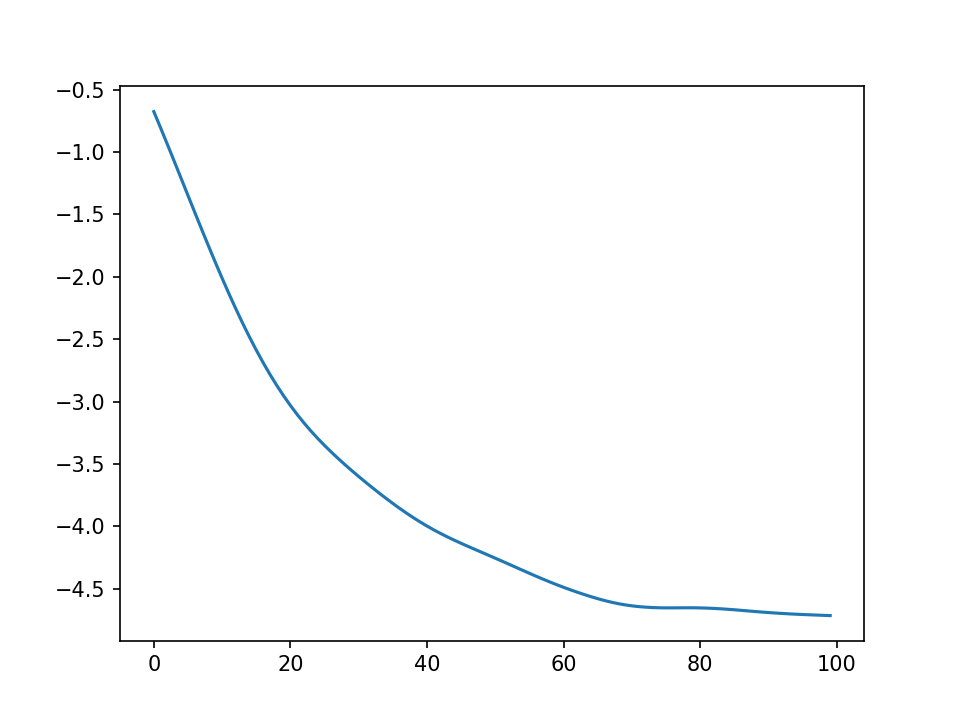

In [3]:
n = 2
d = 2**n
np.random.seed(42)
hamiltonian = random_hamiltonian(d)
rbm = RBM(n_vis=n, n_hid=2, hamiltonian=hamiltonian)



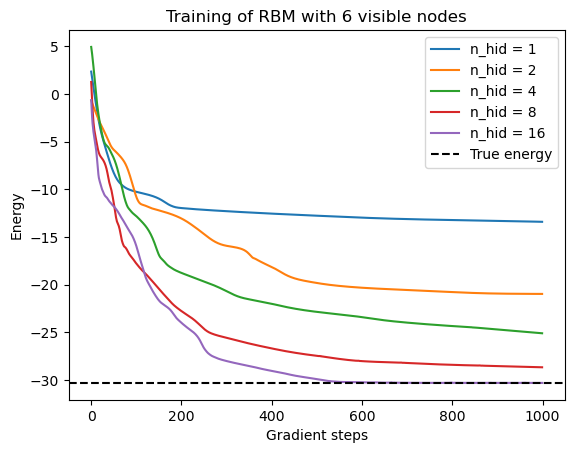

In [50]:
labels = [f"n_hid = {i}" for i in n_hid_list]


for energy in energy_list:
    plt.plot(energy)
    plt.xlabel('Gradient steps')
    plt.ylabel('Energy')

plt.title(f"Training of RBM with {n} visible nodes")
plt.axhline(y=E_truth, color='k', linestyle='--')
labels.append("True energy")
plt.legend(labels)


In [52]:
n = 7
n_hid = 1
d = 2**n
np.random.seed(45)

hamiltonian = random_hamiltonian(d)
eig,_ = np.linalg.eigh(hamiltonian)
E_truth = np.min(eig)
print(f"Energy truth: {E_truth}")

iterations = 5
energy_list = []
n_hid_list =[]

for i in tqdm(range(iterations)):
    np.random.seed(45)
    hamiltonian = random_hamiltonian(d)

    rbm = RBM(n_vis=n, n_hid=n_hid, hamiltonian=hamiltonian)
    energy_list.append(rbm.train(iter=1000, lr=0.01))
    n_hid_list.append(n_hid)
    n_hid *= 2

Energy truth: -43.4706807083632


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0.8800271969717028
0.7177820970624131
0.5541709665197301
0.38930260903880004
0.2230501666063382
0.05498865483164389
-0.11544101148408376
-0.2887560479339223
-0.465404014014208
-0.6457456917173654
-0.8300350714812877
-1.0184300965639488
-1.2110202189032493
-1.4078494253375327
-1.6089277660648715
-1.814232214590263
-2.023698847319208
-2.237207869503405
-2.4545632191513898
-2.675469755384423
-2.8995125470352945
-3.126143253834332
-3.354677791685314
-3.5843083206868918
-3.814131754510148
-4.043195969580701
-4.270562224436094
-4.495376128265238
-4.716929407560712
-4.934685949217971
-5.148250827230285
-5.357287933385127
-5.56142350305428
-5.7601794834317
-5.952958517985719
-6.139075431319599
-6.317816961317357
-6.48851159088502
-6.650596443401373
-6.80367279495697
-6.947544672177386
-7.082237127251497
-7.207993008989034
-7.325249615035766
-7.43459920568257
-7.53673947794152
-7.63242130939812
-7.722401118519793
-7.807403931978897
-7.888100758449134
-7.96510050168453
-8.038953154497994
-8.1101

-14.437659998842683
-14.444248558645164
-14.45075146596582
-14.457169601649259
-14.46350388007855
-14.469755247265674
-14.475924678933628
-14.482013178595881
-14.488021775638678
-14.493951523411138
-14.499803497328308
-14.505578792991619
-14.51127852433133
-14.516903821775013
-14.522455830446008
-14.527935708395272
-14.53334462487033
-14.53868375862386
-14.543954296265031
-14.549157430656017
-14.55429435935579
-14.55936628311327
-14.564374404411437
-14.569319926063963
-14.57420404986544
-14.579027975296238
-14.583792898282725
-14.588500010013352
-14.593150495810988
-14.59774553406153
-14.602286295198837
-14.606773940745711
-14.611209622410584
-14.615594481239304
-14.619929646821426
-14.62421623655023
-14.628455354935427
-14.63264809296762
-14.636795527533442
-14.640898720880049
-14.644958720127763
-14.6489765568295
-14.652953246575493
-14.656889788642
-14.66078716568236
-14.664646343458855
-14.668468270613925
-14.672253878479026
-14.676004080919572
-14.679719774214364
-14.6834018369679

-15.33659695231097
-15.336789300922602
-15.336979122394817
-15.337166456750301
-15.337351343392822
-15.337533821114153
-15.33771392810108
-15.33789170194235
-15.33806717963577
-15.33824039759523
-15.338411391657807
-15.33858019709086
-15.338746848599147
-15.338911380331933
-15.33907382589013
-15.339234218333374
-15.33939259018716
-15.339548973449928
-15.339703399600143
-15.339855899603377
-15.340006503919314
-15.340155242508787
-15.340302144840752
-15.340447239899271
-15.340590556190385
-15.340732121749024
-15.340871964145848
-15.341010110494018
-15.341146587455988
-15.341281421250207
-15.341414637657701
-15.341546262028826
-15.341676319289661
-15.341804833948617
-15.341931830102826
-15.34205733144454
-15.34218136126745
-15.342303942472949
-15.34242509757636
-15.342544848713029
-15.342663217644413
-15.342780225764113
-15.342895894103787
-15.343010243339076
-15.343123293795335
-15.343235065453442
-15.34334557795546
-15.343454850610193
-15.343562902398823
-15.34366975198023
-15.343775417

  0%|          | 0/1000 [00:00<?, ?it/s]

1.1762568384969445
0.9558868848151779
0.7432883080197278
0.5357592555992782
0.3327253609252753
0.1340049754065158
-0.06051057240159405
-0.2509941552075924
-0.4377483499089875
-0.6211572953927469
-0.8015333979195498
-0.979024921993998
-1.1536512819602787
-1.3253802065102591
-1.4941848175113057
-1.6600741715217764
-1.8231082592827343
-1.9834071697500522
-2.1411589886766187
-2.2966263340820645
-2.450147394370447
-2.6021246778721165
-2.752996357460635
-2.9031924745372693
-3.053086910816681
-3.2029592573760057
-3.3529772082310254
-3.503203952447895
-3.653629759857279
-3.8042229784994417
-3.9549918261100983
-4.106043763519128
-4.257625220477268
-4.410127292727508
-4.564059780533049
-4.720018286817917
-4.878673070156191
-5.040787307270788
-5.207246759573842
-5.379066664215353
-5.557333197928886
-5.743043949029697
-5.936856786963933
-6.138831764712693
-6.3482966485143955
-6.563940268552665
-6.7841417155144965
-7.00738903950491
-7.232515352097692
-7.458560154212158
-7.684361975942435
-7.9081998

-20.40153106226014
-20.406727967713415
-20.411888154873093
-20.41701181706052
-20.422099148203987
-20.427150342815366
-20.432165595969547
-20.437145103286085
-20.44208906091321
-20.446997665513898
-20.45187111425384
-20.456709604791367
-20.461513335268783
-20.466282504305312
-20.4710173109914
-20.475717954884068
-20.48038463600339
-20.485017554829795
-20.489616912302118
-20.49418290981623
-20.49871574922419
-20.50321563283361
-20.507682763407388
-20.512117344163407
-20.516519578774272
-20.52088967136697
-20.52522782652217
-20.529534249273443
-20.533809145105845
-20.53805271995424
-20.5422651802009
-20.546446732672685
-20.55059758463741
-20.55471794379959
-20.558808018295466
-20.562868016687126
-20.566898147955918
-20.570898621495054
-20.574869647101217
-20.578811434965473
-20.582724195663143
-20.586608140142964
-20.59046347971524
-20.59429042603921
-20.598089191109512
-20.601859987241795
-20.60560302705761
-20.609318523468332
-20.613006689658363
-20.616667739067683
-20.6203018853735
-2

-21.548821228632214
-21.551472559676643
-21.5541148247109
-21.556748382007587
-21.559373599898485
-21.56199085654639
-21.56460053972545
-21.56720304660972
-21.569798783569816
-21.57238816597775
-21.574971618019426
-21.57754957251485
-21.580122470745792
-21.582690762290547
-21.585254904865618
-21.58781536417422
-21.590372613760877
-21.592927134872305
-21.595479416323997
-21.598029954372148
-21.60057925259081
-21.60312782175368
-21.605676179720234
-21.608224851325833
-21.610774368275386
-21.613325269040054
-21.61587809875647
-21.618433409128233
-21.620991758328774
-21.623553710905334
-21.62611983768314
-21.628690715669364
-21.63126692795595
-21.633849063620666
-21.636437717625526
-21.639033490711558
-21.64163698928913
-21.644248825322755
-21.646869616209187
-21.649499984647782
-21.652140558501575
-21.654791970648134
-21.657454858818387
-21.66012986542203
-21.66281763735791
-21.665518825807595
-21.66823408601028
-21.670964077017192
-21.673709461423236
-21.67647090507395
-21.67924907674525

  0%|          | 0/1000 [00:00<?, ?it/s]

-1.4494651900744835
-1.7937458514763807
-2.1283294126914925
-2.450666321381093
-2.757976030876903
-3.0480655644947383
-3.3198193426077895
-3.573883478564696
-3.812346253744739
-4.037843992833931
-4.252993336000679
-4.460054349599007
-4.660643305227409
-4.855575677304865
-5.0449114121153364
-5.2281559362229615
-5.404519024662367
-5.57315419123605
-5.733348512229773
-5.88466224080062
-6.027019938253111
-6.160745920514914
-6.286535439319417
-6.405365574244552
-6.518367109358607
-6.626689492595044
-6.731391559015146
-6.833380972134438
-6.933407641826928
-7.0320980123787145
-7.130006340812043
-7.227658737063247
-7.325572857514693
-7.424246003837071
-7.524113568577031
-7.625486834516697
-7.728483836184534
-7.832969239216594
-7.938518723140701
-8.044420626649385
-8.14972437058516
-8.253342844187754
-8.354212824793395
-8.451506827195699
-8.544861346942035
-8.634539260940542
-8.721413728904635
-8.806720505854646
-8.891685826051425
-8.977248174481588
-9.064011688781996
-9.15238792332715
-9.24277

-26.076387610174375
-26.096256315139033
-26.116080295145018
-26.135843780294955
-26.155530344065852
-26.175123312872984
-26.19460621871559
-26.213963267866234
-26.233179794117614
-26.25224266429658
-26.27114060739691
-26.289864446741472
-26.30840722596062
-26.326764232173325
-26.34493293096867
-26.362912835182037
-26.380705331586515
-26.398313486519214
-26.415741844726874
-26.432996227936435
-26.450083533522072
-26.467011530976393
-26.48378865505909
-26.500423798386855
-26.516926110814172
-26.533304816144764
-26.5495690571342
-26.565727777160646
-26.58178964219578
-26.59776300127803
-26.613655879082636
-26.629475991428052
-26.645230773964805
-26.660927415479613
-26.676572889419838
-26.69217397954587
-26.707737297438346
-26.723269290701644
-26.738776241274994
-26.754264253653254
-26.769739233398276
-26.785206857269
-26.80067253752872
-26.816141384189873
-26.831618169737624
-26.84710730092675
-26.862612801481333
-26.878138308110906
-26.893687080546826
-26.909262024710486
-26.924865726974

-30.4259551550986
-30.435988564586527
-30.4459393499072
-30.455805792832493
-30.465586735784235
-30.475281502498394
-30.484889790324317
-30.494411487618205
-30.503846362215548
-30.51319407515554
-30.522454074778192
-30.531625857844336
-30.54070903200899
-30.549703485236343
-30.558609347964513
-30.567426885727542
-30.576156395671727
-30.58479805841091
-30.59335199023657
-30.601818251162282
-30.610196993299812
-30.618488491469314
-30.62669315569595
-30.634811478754965
-30.642843936921395
-30.650790986765763
-30.65865303188729
-30.666430516725292
-30.674123944287487
-30.68173391556126
-30.689261108295277
-30.6967062193061
-30.70406996439463
-30.711353036769044
-30.71855617126994
-30.725680141397937
-30.732725792010022
-30.73969402716913
-30.74658577225381
-30.753401983712497
-30.760143612253152
-30.766811650632967
-30.77340712126331
-30.77993109568836
-30.78638468744415
-30.79276902376587
-30.79908526232137
-30.80533456285509
-30.81151812256354
-30.817637163589396
-30.823692941214425
-30.

  0%|          | 0/1000 [00:00<?, ?it/s]

0.41291856829586016
0.10615704683090388
-0.16465645394079384
-0.41108486403234223
-0.6441559674670134
-0.8742654734749058
-1.1115439229583335
-1.366066380290643
-1.6478917861283198
-1.9670835444761363
-2.333223952468105
-2.752674172174739
-3.2202284752508525
-3.7038338084550175
-4.132737920157522
-4.425667969254919
-4.595616549647067
-4.749944153040657
-4.9455461559303275
-5.178194382336525
-5.433380477118678
-5.702537754100826
-5.975188470330956
-6.233165212746651
-6.458363199276185
-6.645905508636821
-6.80831778808321
-6.966950551355808
-7.140493958831956
-7.337717103852665
-7.554835730384303
-7.777335996180045
-7.987006960115323
-8.173186493075548
-8.341463567015198
-8.51030285302831
-8.696302416143752
-8.90194327622045
-9.116612135524967
-9.327754214389971
-9.53112030567127
-9.731991881038297
-9.938466022884384
-10.154129222313706
-10.375541993704735
-10.59480149368396
-10.804511986618113
-11.00179681017028
-11.188692677465266
-11.368873047103039
-11.543783390857211
-11.71151510963

-32.72191063603701
-32.735558384688474
-32.749257372201626
-32.76301839645876
-32.7768522407332
-32.7907692764709
-32.80477968719841
-32.8188935385991
-32.83312051814396
-32.847470140693815
-32.86195142763212
-32.87657329811005
-32.89134411641642
-32.90627203649619
-32.92136466989151
-32.93662938779704
-32.952073059090125
-32.967702194286204
-32.98352285581666
-32.99954066901195
-33.01576082037203
-33.03218793341907
-33.04882619124112
-33.06567911263606
-33.082749686842924
-33.100040120101326
-33.11755201536275
-33.135286105522525
-33.15324236904999
-33.17141982163645
-33.189816648241596
-33.20843003111436
-33.227256204373184
-33.24629034992992
-33.26552669939723
-33.28495846572791
-33.30457789011485
-33.32437621173047
-33.34434379025628
-33.364470102226974
-33.384743821247234
-33.40515282257358
-33.4256843359905
-33.44632498081096
-33.46706087091589
-33.487877638885436
-33.50876058891012
-33.529694758681785
-33.55066502148943
-33.571656124408086
-33.592652813745026
-33.61363990845534


-36.526415689296044
-36.52716183544369
-36.53377401037172
-36.537319635048505
-36.54112285180581
-36.5457622017051
-36.54934015294559
-36.5545711955371
-36.55787910823382
-36.562459142445604
-36.56692184926787
-36.5709103057593
-36.57571819681916
-36.57946347728921
-36.58426299794671
-36.588765189139444
-36.5927614328121
-36.59786322405162
-36.60201891794718
-36.60643413922001
-36.61137009559681
-36.61590125359348
-36.62071533314504
-36.62531910045019
-36.63005306272167
-36.63492649009292
-36.63970205385685
-36.6448953948818
-36.649909658667454
-36.654866378564975
-36.66012768802544
-36.66522520985241
-36.67043501880731
-36.67580293026062
-36.6811257648794
-36.686543959296
-36.69187477509115
-36.697054490391466
-36.70180268245967
-36.70540034580929
-36.707533211235685
-36.709417976110345
-36.71595558886702
-36.72892017271396
-36.73924175723472
-36.74205230376684
-36.74340209470478
-36.74947528397201
-36.75471427830871
-36.75790176927303
-36.763625095438144
-36.77889814647709
-36.789588

  0%|          | 0/1000 [00:00<?, ?it/s]

-0.19350594935860682
-0.7948502546980494
-1.594124563056174
-2.619518266693125
-3.7796331019776943
-4.821010437931497
-5.465903434595102
-5.717328776465804
-5.799676313601491
-5.875407777423918
-6.027760418328686
-6.298597563069898
-6.699406977671963
-7.2122365001771165
-7.791672740967862
-8.37053789538033
-8.872696921767023
-9.242849331935844
-9.474339965941198
-9.60574787107409
-9.727461369710836
-9.92967394868924
-10.206248291296971
-10.495541557367535
-10.765115925862919
-11.032740222681099
-11.32304953236288
-11.62621950959299
-11.899096649843074
-12.0959142680132
-12.198739470788864
-12.225908168581228
-12.221970406884834
-12.23773988529798
-12.302356428394148
-12.406434676998266
-12.518770796334532
-12.617277858007645
-12.700088151990919
-12.775755521390167
-12.851875865155698
-12.929870345682703
-13.005129229517394
-13.07524710282707
-13.148446031092472
-13.236685522371364
-13.3410827095177
-13.451871827811587
-13.560878406175789
-13.666523106121737
-13.767845037571927
-13.8615

-38.42516202468653
-38.43671233111401
-38.44879152705393
-38.46154801576817
-38.473934361494784
-38.48591673742658
-38.49870517957308
-38.51165383928971
-38.523293357197716
-38.53409466317204
-38.545642049733075
-38.55821859136745
-38.57046884626264
-38.581865724273406
-38.59285109021475
-38.60344880349338
-38.6133745004117
-38.621693907863474
-38.629815317416885
-38.63789115905186
-38.64931503136508
-38.663781559632646
-38.6830270585923
-38.703366020038104
-38.72124284585493
-38.734279187686404
-38.74378315265718
-38.75280232623449
-38.76359400714193
-38.77757403469282
-38.793601268111544
-38.809954543752426
-38.82429206054102
-38.836131983730944
-38.84675640724669
-38.8578839970926
-38.87045532049497
-38.88412510250552
-38.898075576135355
-38.911354725799484
-38.9234793832519
-38.93465382694113
-38.94562803492742
-38.95710256248096
-38.969257916529
-38.98173871485372
-38.99404849812116
-39.00586843878925
-39.01719005291527
-39.02820900589815
-39.039207961255656
-39.050408265957905
-3

-42.12719049163658
-42.13549393867835
-42.14287153046077
-42.14732970660839
-42.150039506802436
-42.15186315957834
-42.15424081073594
-42.15762530567851
-42.16306572975494
-42.1705480795392
-42.17838532083107
-42.184335129385886
-42.18757233228317
-42.189019985527565
-42.19078280913679
-42.194284735957304
-42.19954252873953
-42.20509601666727
-42.20942475410606
-42.212065262947405
-42.21356484529697
-42.21531768778414
-42.218082957793946
-42.222267930496386
-42.226880553966765
-42.23116433271464
-42.23401577744269
-42.23558272806291
-42.23558645193606
-42.23517454094837
-42.23339315378499
-42.23220098465919
-42.229390854779396
-42.229200784093685
-42.2289658440901
-42.23519424684364
-42.24218853783129
-42.25353843484891
-42.2597655484478
-42.26508841766265
-42.26473573268634
-42.26508174247964
-42.26514140392669
-42.265023759739876
-42.26513699058842
-42.26759049640501
-42.27788580037259
-42.294131699995475
-42.30856748496033
-42.313756234838394
-42.31050588641381
-42.307251996402705
-

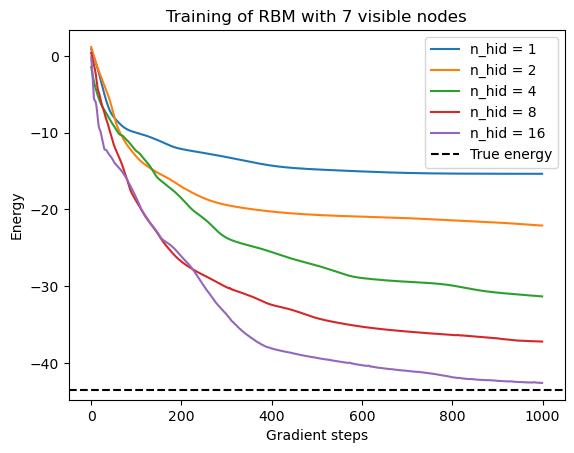

In [53]:
labels = [f"n_hid = {i}" for i in n_hid_list]


for energy in energy_list:
    plt.plot(energy)
    plt.xlabel('Gradient steps')
    plt.ylabel('Energy')

plt.title(f"Training of RBM with {n} visible nodes")
plt.axhline(y=E_truth, color='k', linestyle='--')
labels.append("True energy")
plt.legend(labels)

In [3]:
n = 7
n_hid = 8
d = 2**n
np.random.seed(45)

hamiltonian = random_hamiltonian(d)
eig,_ = np.linalg.eigh(hamiltonian)
E_truth = np.min(eig)
print(f"Energy truth: {E_truth}")

iterations = 5
energy_list = []
n_hid_list =[]

for i in tqdm(range(iterations)):
    np.random.seed(45)
    hamiltonian = random_hamiltonian(d)

    rbm = RBM(n_vis=n, n_hid=n_hid, hamiltonian=hamiltonian)
    energy_list.append(rbm.train(iter=1000, lr=0.01))
    n_hid_list.append(n_hid)
    n_hid += 5

Energy truth: -43.4706807083632


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0.41291856829586016
0.10615704683090388
-0.16465645394079384
-0.41108486403234223
-0.6441559674670134
-0.8742654734749058
-1.1115439229583335
-1.366066380290643
-1.6478917861283198
-1.9670835444761363
-2.333223952468105
-2.752674172174739
-3.2202284752508525
-3.7038338084550175
-4.132737920157522
-4.425667969254919
-4.595616549647067
-4.749944153040657
-4.9455461559303275
-5.178194382336525
-5.433380477118678
-5.702537754100826
-5.975188470330956
-6.233165212746651
-6.458363199276185
-6.645905508636821
-6.80831778808321
-6.966950551355808
-7.140493958831956
-7.337717103852665
-7.554835730384303
-7.777335996180045
-7.987006960115323
-8.173186493075548
-8.341463567015198
-8.51030285302831
-8.696302416143752
-8.90194327622045
-9.116612135524967
-9.327754214389971
-9.53112030567127
-9.731991881038297
-9.938466022884384
-10.154129222313706
-10.375541993704735
-10.59480149368396
-10.804511986618113
-11.00179681017028
-11.188692677465266
-11.368873047103039
-11.543783390857211
-11.71151510963

-32.70830275928668
-32.72191063603701
-32.735558384688474
-32.749257372201626
-32.76301839645876
-32.7768522407332
-32.7907692764709
-32.80477968719841
-32.8188935385991
-32.83312051814396
-32.847470140693815
-32.86195142763212
-32.87657329811005
-32.89134411641642
-32.90627203649619
-32.92136466989151
-32.93662938779704
-32.952073059090125
-32.967702194286204
-32.98352285581666
-32.99954066901195
-33.01576082037203
-33.03218793341907
-33.04882619124112
-33.06567911263606
-33.082749686842924
-33.100040120101326
-33.11755201536275
-33.135286105522525
-33.15324236904999
-33.17141982163645
-33.189816648241596
-33.20843003111436
-33.227256204373184
-33.24629034992992
-33.26552669939723
-33.28495846572791
-33.30457789011485
-33.32437621173047
-33.34434379025628
-33.364470102226974
-33.384743821247234
-33.40515282257358
-33.4256843359905
-33.44632498081096
-33.46706087091589
-33.487877638885436
-33.50876058891012
-33.529694758681785
-33.55066502148943
-33.571656124408086
-33.592652813745026


-36.526415689296044
-36.52716183544369
-36.53377401037172
-36.537319635048505
-36.54112285180581
-36.5457622017051
-36.54934015294559
-36.5545711955371
-36.55787910823382
-36.562459142445604
-36.56692184926787
-36.5709103057593
-36.57571819681916
-36.57946347728921
-36.58426299794671
-36.588765189139444
-36.5927614328121
-36.59786322405162
-36.60201891794718
-36.60643413922001
-36.61137009559681
-36.61590125359348
-36.62071533314504
-36.62531910045019
-36.63005306272167
-36.63492649009292
-36.63970205385685
-36.6448953948818
-36.649909658667454
-36.654866378564975
-36.66012768802544
-36.66522520985241
-36.67043501880731
-36.67580293026062
-36.6811257648794
-36.686543959296
-36.69187477509115
-36.697054490391466
-36.70180268245967
-36.70540034580929
-36.707533211235685
-36.709417976110345
-36.71595558886702
-36.72892017271396
-36.73924175723472
-36.74205230376684
-36.74340209470478
-36.74947528397201
-36.75471427830871
-36.75790176927303
-36.763625095438144
-36.77889814647709
-36.789588

  0%|          | 0/1000 [00:00<?, ?it/s]

0.7616059778431066
0.25306690865026504
-0.3135743217145653
-0.9018631046067891
-1.464907573203048
-1.950353389305135
-2.3295506322070567
-2.6132373508643036
-2.8298252250912963
-3.0140376800321125
-3.2061497930178584
-3.4409565530861315
-3.7351455013349617
-4.083664979594093
-4.46188967507189
-4.824859728356049
-5.107090453461983
-5.249257454915338
-5.286827112663691
-5.3583218180581405
-5.54229812905735
-5.821172716509382
-6.122376245608591
-6.3609006859751505
-6.496005794135847
-6.580233060499742
-6.714664114630503
-6.93843194495026
-7.2136785250349345
-7.480401358582476
-7.70846253915516
-7.912131565198365
-8.122487653593371
-8.352847921837755
-8.586643635383542
-8.791742711317314
-8.960297675960538
-9.139317803370188
-9.37873525583101
-9.665035129797634
-9.953036637625996
-10.2338341738458
-10.535789529765399
-10.869559077927658
-11.207519727323398
-11.52151367111124
-11.817994845473134
-12.113144210462663
-12.39422094916246
-12.638731993955933
-12.856482055734997
-13.0760463528495

-40.71975790480218
-40.72905833626578
-40.74494704885937
-40.7617742397109
-40.775600416770146
-40.78532889254011
-40.7944104801384
-40.80572570191562
-40.8176777735643
-40.82762164919584
-40.8343641024727
-40.83950266208986
-40.84600350165617
-40.856545854471506
-40.86973970812527
-40.88170593610177
-40.89006473530768
-40.89517515307722
-40.89903714163454
-40.903982632476584
-40.91151668203334
-40.921316459501504
-40.93188349189158
-40.94132159639469
-40.94874083110184
-40.95428415196097
-40.958765798894646
-40.963004652381535
-40.967447543055656
-40.97238627156169
-40.97764351462148
-40.982790208707044
-40.9865733107603
-40.986999411282234
-40.98097571451093
-40.966866292579596
-40.95208095153461
-40.95644666047785
-40.99149245481061
-41.020111039368146
-41.016638308800495
-40.99981258269875
-41.005212938051514
-41.03998546139532
-41.0589275617929
-41.047167436249595
-41.03730990487348
-41.04949808540838
-41.06833572194052
-41.070686441433786
-41.065604745636364
-41.072630268789474
-

-41.68919644793338
-41.658125686555294
-41.61250935608426
-41.63056609932977
-41.68902262712108
-41.67898346093888
-41.63934109847398
-41.662855514837084
-41.69796902761455
-41.68654840830307
-41.66636176975262
-41.68335042979405
-41.70488291894897
-41.692123929342785
-41.68017024172906
-41.69977417219663
-41.70956512954558
-41.69842745404273
-41.69740614382965
-41.71030425072354
-41.714240340268965
-41.70734627221744
-41.7076006910647
-41.717215763300146
-41.719421387784465
-41.71481950322536
-41.71620970091575
-41.72279932633165
-41.72490232035093
-41.72249200182465
-41.72309764076583
-41.72766042321675
-41.73025890249197
-41.729385186205704
-41.72948671748677
-41.732364132298
-41.7352208751165
-41.735690400629785
-41.73554073478499
-41.73715966170721
-41.73966653947321
-41.74125380437921
-41.741672509759155
-41.74233052548832
-41.74398900402815
-41.74595428715541
-41.74725554407233
-41.747963189836696
-41.7488442360698
-41.75024383037212
-41.7517705599505
-41.75291900499632
-41.7534

  0%|          | 0/1000 [00:00<?, ?it/s]

-3.1214574244816884
-5.614343060060021
-7.029811558772982
-7.622399563547934
-7.787113431628997
-7.833694562150848
-7.933138374436387
-8.148977526325499
-8.489779825313425
-8.938409196950477
-9.456244245900923
-9.979912471208948
-10.427234470972795
-10.725722839493962
-10.856375525833931
-10.869815184181356
-10.84656891797891
-10.845944807943045
-10.889681850961034
-10.972875974430302
-11.081446602097376
-11.205462629865863
-11.343780490923152
-11.501009865409108
-11.682031715922552
-11.886911638742465
-12.106370317269018
-12.317577844192808
-12.482215024678553
-12.558330499684082
-12.549286365269413
-12.547691389698183
-12.634999386135235
-12.77949222401371
-12.893746986946198
-12.936423685510437
-12.943703617611156
-12.973136224412453
-13.040830746765838
-13.115682492346174
-13.15723053242385
-13.155720744499583
-13.139799443697424
-13.146062518393993
-13.185088076837063
-13.23828994282821
-13.28071835585439
-13.303180733713889
-13.315295802424856
-13.33214092402267
-13.3602633243375

-38.449640631296894
-38.460718601927134
-38.471846846455946
-38.48303235296396
-38.494277999977754
-38.50558139816913
-38.51692894001109
-38.52828757237278
-38.53958226046231
-38.550672468661304
-38.561279549020334
-38.57097843226036
-38.57913284141425
-38.58558973533239
-38.59137268267618
-38.600834754612734
-38.61764734752195
-38.6402950883229
-38.659574002579376
-38.670278736124004
-38.67628379091033
-38.68689582789393
-38.70564048629468
-38.72727475830168
-38.743387778366966
-38.753847279325
-38.76512988403045
-38.78121209596968
-38.79911662550583
-38.813944855972416
-38.82608963048446
-38.839720064169526
-38.85687937604795
-38.87477454306276
-38.89022068492751
-38.903729998496985
-38.91810702054368
-38.934441969380615
-38.95107450921857
-38.966398188209425
-38.980897169287324
-38.99616194566526
-39.01249983303491
-39.02878945028333
-39.04402790664094
-39.05853128711317
-39.07321998973765
-39.08836383791264
-39.10339217998023
-39.11772014786129
-39.131451698832876
-39.1450619600726

-42.006324293479544
-42.01096101146166
-42.015485039461446
-42.01772693289252
-42.0188327094679
-42.02121617173421
-42.02535683302369
-42.02925321448088
-42.031684594463144
-42.03342921700907
-42.035741054417905
-42.03897655267433
-42.042312564229405
-42.04524158333507
-42.04777759452647
-42.0501710382065
-42.05255710245477
-42.0549948568968
-42.05757433826297
-42.06027444201412
-42.06298086881602
-42.06552811102475
-42.06789065214855
-42.07016165588533
-42.07242665377496
-42.07460547157133
-42.07654186038208
-42.07806896594013
-42.07905298998493
-42.07917768475927
-42.077978931777636
-42.074540289120655
-42.06868678057076
-42.060252380915486
-42.053979477578196
-42.053767105779556
-42.06601822838299
-42.08535790251533
-42.10182724725104
-42.10783946738929
-42.10428546277373
-42.098117478499255
-42.096109807348
-42.10156802089485
-42.11155419010714
-42.12014752542903
-42.12357978325372
-42.12245488623522
-42.12059146919809
-42.12154131607221
-42.12612356911702
-42.13233641958199
-42.13

  0%|          | 0/1000 [00:00<?, ?it/s]

-1.0781207311922096
-1.7293884982333423
-2.1665013712892125
-2.5339310412152845
-2.867598971910348
-3.1665417359495898
-3.4237026781185844
-3.6826073607635843
-4.087206791470903
-4.7908825653578795
-5.753505867730739
-6.6545584106240625
-7.096665880572232
-7.05370047489447
-6.869577610984547
-6.836245855090947
-7.057464884776673
-7.499310503175725
-8.05043772416917
-8.565042296845608
-8.856852681460037
-8.78991798731492
-8.706925571912903
-8.90017764766331
-9.231651014807568
-9.441822475003804
-9.43266039306673
-9.329697976067001
-9.276688914706428
-9.32021070458445
-9.43703831821179
-9.577273725439383
-9.689650700890796
-9.743699030741407
-9.755628383347378
-9.777845997834401
-9.837943969002517
-9.909060923220602
-9.949898870228978
-9.956520481004068
-9.960664416795506
-9.986595453777475
-10.02900049779234
-10.069117945544043
-10.098627176248478
-10.125059366704658
-10.160142141726094
-10.20672355951647
-10.25494123668933
-10.291173530515678
-10.312754122032048
-10.332029894808631
-10

-37.40041530195145
-37.41017214471856
-37.421087937072286
-37.436037758946476
-37.4479628742165
-37.45704476771805
-37.461404971578105
-37.46788050937975
-37.48247402172841
-37.51657847192983
-37.5348137236303
-37.52946933703204
-37.53784701952307
-37.5540769578721
-37.57761368870887
-37.59606582159116
-37.60976266038524
-37.61804278644908
-37.627395239907315
-37.642869074054474
-37.65530302453502
-37.66478559025249
-37.67909481567134
-37.698025522543986
-37.71129233557316
-37.719919077212
-37.7280669398678
-37.73686264161728
-37.74736329041129
-37.760080802087856
-37.775552531519004
-37.789929999690386
-37.80316072014639
-37.81480967223493
-37.825740547568984
-37.836669910263865
-37.84706277708217
-37.85693313507163
-37.86639789290409
-37.875579408535
-37.88350144425593
-37.894867748934956
-37.90800731579546
-37.925348035014764
-37.94141870483567
-37.95444634103584
-37.964072192513854
-37.97182916670396
-37.98128483034941
-37.993126213273314
-38.00761104354686
-38.02153056795562
-38.0

-41.38478359775572
-41.38804740422033
-41.390701074433196
-41.39245578318005
-41.3934378153762
-41.39291450292427
-41.39176110253697
-41.38835794523514
-41.386255820287225
-41.38297303345833
-41.38658965913763
-41.39278777075792
-41.40691116634464
-41.42105668735503
-41.43252993824818
-41.43790103403664
-41.43799637055227
-41.43616334283139
-41.43544420252187
-41.439275230724824
-41.44604834821069
-41.45476293424487
-41.46193658657868
-41.46623523921104
-41.46798587526862
-41.4687647618337
-41.47058077382094
-41.474031178805575
-41.47937744212672
-41.485176209705244
-41.490410962159025
-41.494355210025006
-41.497126925859796
-41.49937743042561
-41.5017902122812
-41.50492747539884
-41.50871421206698
-41.51297573494189
-41.517203728051435
-41.52109080840935
-41.52448378925659
-41.52745328072212
-41.53019174542778
-41.53289989853126
-41.53574638058135
-41.538754305102586
-41.54193025483386
-41.54515149869994
-41.54833624053033
-41.551364330312595
-41.55415084912854
-41.55661624182712
-41.

  0%|          | 0/1000 [00:00<?, ?it/s]

2.09171034195617
-0.3389379080812747
-3.011520934472993
-4.836680749267326
-5.420472026586122
-5.5469744181776255
-5.775886573134749
-6.08899860868941
-6.389225993770094
-6.638994368243962
-6.834279963278141
-6.976195972209222
-7.0677090116618055
-7.114100621985397
-7.133455384242906
-7.15887840856389
-7.196163092356736
-7.233824774232386
-7.263512651154306
-7.283687245012635
-7.300999205083506
-7.3251645880200975
-7.363591237201256
-7.419831439072878
-7.493248441397235
-7.578643465771409
-7.669196747859913
-7.763732172247407
-7.867825433505088
-7.978257520183918
-8.070050748276344
-8.114447420680158
-8.111201150113525
-8.092355836993343
-8.091252012696867
-8.116236636825427
-8.160354088340144
-8.223379108051551
-8.301343752326268
-8.374010199232584
-8.427916299283599
-8.47412644965549
-8.532054844008222
-8.608146421462937
-8.69430317490463
-8.779057662052649
-8.857574712657536
-8.933407236907843
-9.012460522005275
-9.099763100340484
-9.201324193225503
-9.319357901799442
-9.44478485087

-30.050605440104217
-30.045807337023547
-30.040790580968846
-30.02842611683365
-30.03237473424315
-30.03992524396141
-30.073745583745403
-30.10328369432235
-30.120072792503013
-30.11978599939802
-30.111929794079177
-30.11064523956648
-30.121042647580303
-30.144473969606118
-30.16642616232037
-30.17858388122403
-30.181008359568793
-30.180128123642568
-30.186127851877163
-30.19771642427273
-30.216954579540655
-30.233452104185723
-30.244392098658654
-30.246227098858082
-30.242459299199965
-30.22533956719816
-30.219057997081233
-30.19628875431914
-30.248274169304583
-30.296894710059235
-30.36115168414765
-30.384554159752636
-30.380124919271317
-30.387776856825372
-30.410322307479845
-30.477174749760778
-30.530061889795704
-30.562855874281475
-30.58239852211215
-30.60541694069375
-30.658756103199508
-30.71551580835526
-30.76831306388967
-30.801542805563905
-30.821063111274633
-30.840600169212607
-30.867899658281356
-30.913197443893715
-30.96332086180211
-31.012028344701655
-31.0510400550908

-41.06728245392623
-41.07684708619259
-41.096471442853904
-41.10410667272255
-41.099432527629595
-41.10044148185219
-41.11367957167943
-41.125867996504525
-41.12819515080197
-41.12801458992459
-41.13435434975284
-41.145767629589216
-41.1534913362438
-41.15592867029366
-41.158548471383
-41.16511227893701
-41.17380774403992
-41.18052162673631
-41.18462204553096
-41.188473198648644
-41.19409509686793
-41.20084951475614
-41.20736297180426
-41.21249282161317
-41.21642602314887
-41.21935840891604
-41.221944922321796
-41.22197768316744
-41.21897731679541
-41.20408253190368
-41.18155957206563
-41.12596052419436
-41.0982780952778
-41.049755104878685
-41.13643950827172
-41.22051221196756
-41.27991358385869
-41.267413353290415
-41.214818811878544
-41.20071848631742
-41.21971741375319
-41.28332471682411
-41.30965845083874
-41.29163364144658
-41.26819403980297
-41.26489797598843
-41.301387790832074
-41.32991802598707
-41.33190983637388
-41.317344576207695
-41.3078311612647
-41.32427952134323
-41.34

<IPython.core.display.Javascript object>


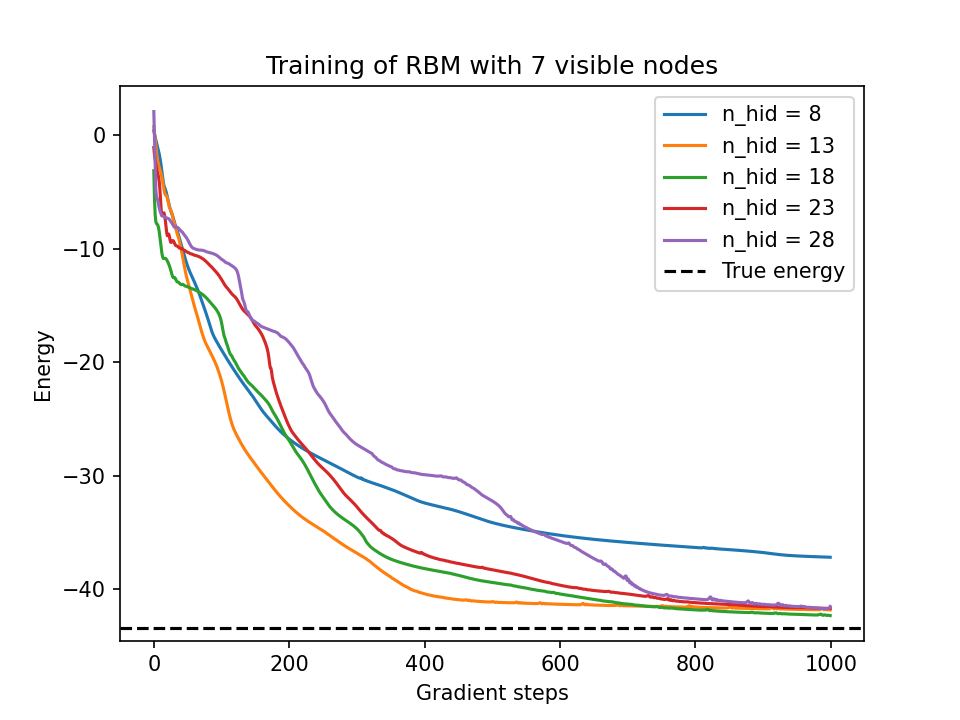

In [13]:
labels = [f"n_hid = {i}" for i in n_hid_list]


for energy in energy_list:
    plt.plot(energy)
    plt.xlabel('Gradient steps')
    plt.ylabel('Energy')

plt.title(f"Training of RBM with {n} visible nodes")
plt.axhline(y=E_truth, color='k', linestyle='--')
labels.append("True energy")
plt.legend(labels)
path = "C:/Users/Sebastian/Desktop/7nodes.pdf"
plt.savefig(path)